In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Exercise 1

### (a) Markov chain

Define the system

In [3]:
#state space
nodes = ['o', 'a', 'b', 'c', 'd']

#transition rates matrix
Lambda = np.array([
            # o    a    b    c    d
            [0.0, 2/5, 1/5, 0.0, 0.0],  # o
            [0.0, 0.0, 3/4, 1/4, 0.0],  # a
            [1/2, 0.0, 0.0, 1/3, 0.0],  # b
            [0.0, 0.0, 1/3, 0.0, 2/3],  # c
            [0.0, 1/3, 0.0, 1/3, 0.0]   # d
        ])

n_simulations = 100000



Compute the probability distribution
$$
\bar{\pi}_i(t) = \mathbb P(X(t) = i), \quad i \in \mathcal X
$$

1st approach: global clock with rate $\omega_*$ and matrix $\bar{P}$, where $\bar P$ is the row-stochastic matrix defined as

$$
\bar P_{ij} = \frac{\Lambda_{ij}}{\omega_{*}}, \; i \neq j \quad \bar P_{ii} = 1 - \sum_{i \neq j} \bar P_{ij}
$$

with $\omega = \Lambda \mathbf{1}$ and $\omega_{*}=\max_i \omega_i$

In [4]:
# omega : The total exit rate for each node (sum of the row)
w = np.sum(Lambda, axis=1)

w_star = np.max(w)
# compute the off-diagonal part of P_bar
P_bar = Lambda/w_star 
# add the diagonal part
P_bar = P_bar + np.diag(np.ones(len(w))-np.sum(P_bar,axis=1))

# compute dominant eigenvector
values,vectors = np.linalg.eig(P_bar.T)
index = np.argmax(values.real)
pi_bar = vectors[:,index].real
pi_bar = pi_bar/np.sum(pi_bar)
print("pi_bar=", pi_bar)

nstates = len(pi_bar)

pi_bar= [0.2173913  0.14906832 0.26086957 0.1863354  0.1863354 ]


In [5]:
#initialize simulation parameters

# number of steps
n_steps = 10000
# pos will keep trace of the visited states
pos = np.zeros(n_steps, dtype=int)

pos[0] = 1 # start from node a

t_next = -np.log(np.random.rand())/w_star

In [6]:
# simulation
def simulate_step(current_node_idx, approach):
    if approach == 1:
        pos[current_node_idx] = np.random.choice(nstates, p=P_bar[pos[current_node_idx-1],:])
        t_next = -np.log(np.random.rand())/w_star
    else:
        pos[current_node_idx] = np.random.choice(nstates, p=P[pos[current_node_idx-1],:])
        t_next = -np.log(np.random.rand())/w[pos[current_node_idx]]

    return pos[current_node_idx], t_next


def get_return_time(start_node_idx, approach=1):
    current = start_node_idx
    total_time = 0
    
    # Force the first step (leave the node)
    current, t = simulate_step(current, approach)
    total_time += t
    
    # Walk until we return
    while current != start_node_idx:
        current, t = simulate_step(current, approach)
        total_time += t

    pos[0] = 1 # reset for next simulation
    return total_time    

In [7]:
times_a = [get_return_time(pos[0], 1) for _ in range(n_simulations)]
avg_return_a = np.mean(times_a)

print(f"Avg return time for node 'a': {avg_return_a:.2f} time units")

Avg return time for node 'a': 6.33 time units


2nd approach: local clocks with rates $\omega_i= \sum_j \Lambda_{ij}$ and matrix $P$, probability to jump to a neighbor $j$ is $P_{ij} = \frac{\Lambda_{ij}}{\omega_i}$


In [8]:
# contruct the P matrix and clock rates w
w = np.sum(Lambda, axis=1)
D = np.diag(w)
P = np.linalg.inv(D) @ Lambda

# number of steps
n_steps = 10000
# pos will keep trace of the visited states
pos = np.zeros(n_steps, dtype=int)

pos[0] = 1 # start from node a


transition_times = np.zeros(n_steps)
t_next = -np.log(np.random.rand())/w[0]

In [9]:
times_a = [get_return_time(pos[0], 2) for _ in range(n_simulations)]
avg_return_a = np.mean(times_a)

print(f"Avg return time for node 'a': {avg_return_a:.2f} time units")

Avg return time for node 'a': 6.22 time units


#### (b) Compute $\mathbb{E}_a[T^+_a]$
Done analytically using the direct consequence of the Ergodic Theorem for continuous-time MC

In [10]:
theoretical_return_a = 1/(pi_bar[1]*w[1])
print(f"Theoretical expectated return time for node 'a': {theoretical_return_a:.4f} time units")

Theoretical expectated return time for node 'a': 6.7083 time units


#### (e) French-DeGroot dynamics

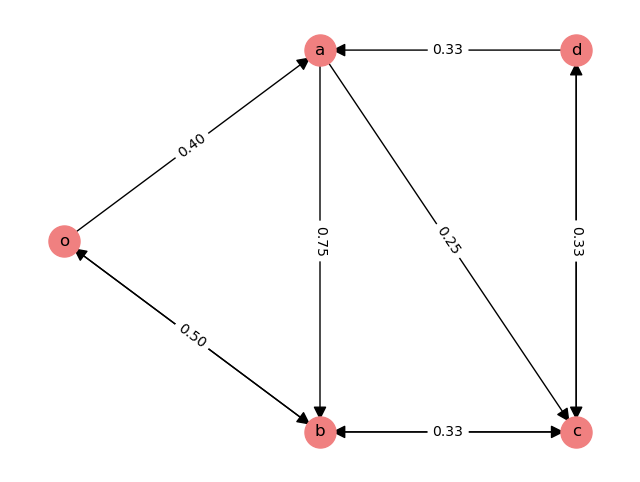

In [11]:
G = nx.DiGraph()
for i, origin in enumerate(nodes):
    for j, target in enumerate(nodes):
        weight = Lambda[i, j]
        if weight > 0:
            G.add_edge(origin, target, weight=weight, label=f"{weight:.2f}")

# Plotting
plt.figure(figsize=(8, 6))
pos = {
    'o': (0, 1),
    'a': (1, 2),
    'b': (1, 0),
    'd': (2, 2),
    'c': (2, 0)
}

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightcoral')
nx.draw_networkx_labels(G, pos)

# Draw edges
nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=20)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.axis('off')
plt.show()

The update rule of the node opinion is $x(t+1) = Px(t)$

In [36]:
w = np.sum(Lambda, axis=1)
P = np.zeros_like(Lambda)
for i in range(len(w)):
    if w[i] > 0:
        P[i, :] = Lambda[i, :] / w[i]

Theorem: if $G=(V,\Epsilon,W)$ possesses a globally reachable aperiodic component $C_0$, then $$\lim_{t\to + \infty}x_i(t)=\pi 'x(0) \: \forall i$$

In [37]:
# Condition A: Strong Connectivity
is_strongly_connected = nx.is_strongly_connected(G)
print(f"1. Is Strongly Connected? {is_strongly_connected}")

# Condition B: Aperiodicity
is_aperiodic = nx.is_aperiodic(G)
print(f"2. Is Aperiodic? {is_aperiodic}")

1. Is Strongly Connected? True
2. Is Aperiodic? True


#### (f) 
Assume that the initial state of the dynamics for each node $i \in V$ is given by $x_i(0) = ξ_i$, where ${ξ_i} \; i\in V$ are independent random variables with variance $$ \sigma_a^2 = \sigma_b^2 = \sigma_a^2 = \sigma_c^2 = 2, \; \sigma_o^2 = \sigma_d^2 = 1$$  
Compute the variance of the consensus value, and compare your results with the numerical simulations.

In [38]:
sigmas_sq = np.array([1.0, 2.0, 2.0, 2.0, 1.0]) 
sigmas = np.sqrt(sigmas_sq)

In [ ]:
# theoretical computation
# Compute pi
vals, vecs = np.linalg.eig(P.T)
idx = np.argmin(np.abs(vals - 1))
pi = vecs[:, idx].real
pi = pi / np.sum(pi)
print(pi)

theoretical_var = np.sum((pi**2) * sigmas_sq)
print(f"Theoretical Variance: {theoretical_var:.5f}")

[0.16153846 0.18461538 0.26923077 0.23076923 0.15384615]
Theoretical Variance: 0.36941


In [40]:
# simulation

num_trials = 20000
consensus_values = []

for i in range(num_trials):
    x = np.random.normal(0, sigmas, 5)
    if i==0:
        x0 = x
        print(f"Initial state x({i}): {x}")
    for n in range(500):
        x = P @ x
        
    consensus_values.append(x[0])

# 4. RESULTS
empirical_var = np.var(consensus_values)

print(f"Empirical Variance:{empirical_var:.5f}")

Initial state x(0): [-0.71212447 -0.77946239  0.90430086  2.67057502  0.2141191 ]
Empirical Variance:0.37229


Centrality matters!